In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

from time import time

In [2]:
# load daily weather data since 1920
# PRCP: precipitation in inches
# TMAX, TMIN: maximum and minimum temperature in Farenheit 
weather = pd.read_csv('3312449.csv', parse_dates=['DATE'])
print(weather.shape)
weather.head()

(37694, 10)


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,USW00023271,"SACRAMENTO 5 ESE, CA US",38.5552,-121.4183,11.6,1920-01-01,0.00,NaN,38.0,36.0
1,USW00023271,"SACRAMENTO 5 ESE, CA US",38.5552,-121.4183,11.6,1920-01-02,0.00,NaN,43.0,34.0
2,USW00023271,"SACRAMENTO 5 ESE, CA US",38.5552,-121.4183,11.6,1920-01-03,0.00,NaN,51.0,36.0
3,USW00023271,"SACRAMENTO 5 ESE, CA US",38.5552,-121.4183,11.6,1920-01-04,0.00,NaN,56.0,32.0
4,USW00023271,"SACRAMENTO 5 ESE, CA US",38.5552,-121.4183,11.6,1920-01-05,0.09,NaN,54.0,43.0


In [3]:
weather.isna().sum()

STATION          0
NAME             0
LATITUDE         0
LONGITUDE        0
ELEVATION        0
DATE             0
PRCP             2
TAVG         36141
TMAX             8
TMIN             5
dtype: int64

In [4]:
# use date column as index
weather = weather.set_index('DATE', drop=True)
# infer datetime frequency
weather = weather.asfreq(pd.infer_freq(weather.index))
# drop unused columns, columns with all nan or all zero
weather.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TAVG'], axis=1, inplace=True)
# fill na with zero
weather.fillna(0, inplace=True)

In [5]:
weather.head()

,PRCP,TMAX,TMIN
DATE,,,
1920-01-01,0.00,38.0,36.0
1920-01-02,0.00,43.0,34.0
1920-01-03,0.00,51.0,36.0
1920-01-04,0.00,56.0,32.0
1920-01-05,0.09,54.0,43.0


Text(0, 0.5, 'Temperature (Fahrenheit)')

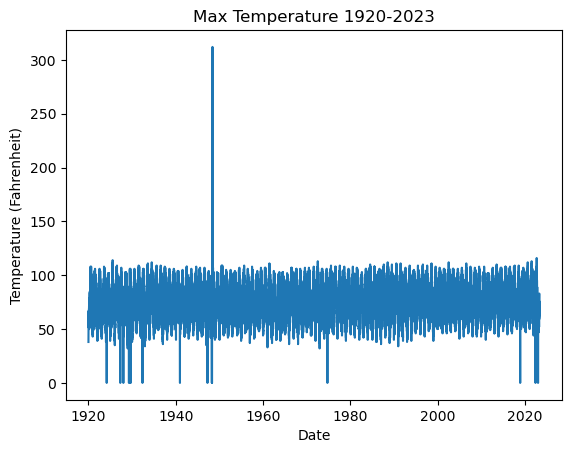

In [6]:
plt.title('Max Temperature 1920-2023')
plt.plot(weather['TMAX'])
plt.xlabel('Date')
plt.ylabel('Temperature (Fahrenheit)')

In [7]:
# downsample data to weekly average
weather_wk = weather.resample('W').mean()
# infer datetime frequency
weather_wk = weather_wk.asfreq(pd.infer_freq(weather_wk.index))


In [8]:
weather_wk.head()

,PRCP,TMAX,TMIN
DATE,,,
1920-01-04,0.000000,47.000000,34.500000
1920-01-11,0.012857,55.285714,35.000000
1920-01-18,0.000000,62.714286,35.285714
1920-01-25,0.028571,57.571429,40.142857
1920-02-01,0.008571,54.428571,41.714286


train and test data subsets for model

In [9]:
# train data
condition = (weather_wk.index >= '2010-01-01') & (weather_wk.index < '2016-01-01')
weather_train = weather_wk.loc[condition, :].copy()
weather_train.head()

,PRCP,TMAX,TMIN
DATE,,,
2010-01-03,0.021429,53.571429,43.428571
2010-01-10,0.008571,50.285714,44.000000
2010-01-17,0.148571,56.714286,45.142857
2010-01-24,0.428571,52.142857,44.000000
2010-01-31,0.080000,56.571429,43.285714


In [10]:
# test data
condition = (weather_wk.index >= '2016-01-01') & (weather_wk.index < '2017-01-01')
weather_test = weather_wk.loc[condition, :].copy()
weather_test.head()

,PRCP,TMAX,TMIN
DATE,,,
2016-01-03,0.005714,50.857143,34.000000
2016-01-10,0.308571,54.000000,42.428571
2016-01-17,0.167143,58.142857,44.857143
2016-01-24,0.300000,61.285714,49.000000
2016-01-31,0.050000,59.571429,46.142857


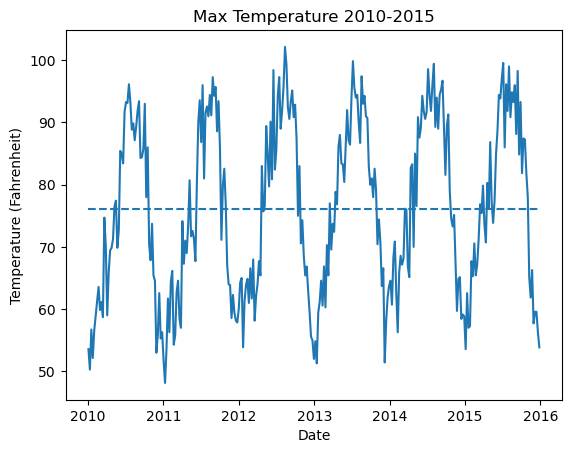

In [11]:
# plot train data
plt.title('Max Temperature 2010-2015')
plt.plot(weather_train['TMAX'])
plt.xlabel('Date')
plt.ylabel('Temperature (Fahrenheit)')

# horizontal dotted line at mean
plt.hlines(y=np.mean(weather_train['TMAX']), xmin=np.min(weather_train.index), xmax=np.max(weather_train.index), linestyles='dashed')

In [12]:
# prep data for heatmap
weather_train['Year'] = weather_train.index.year
weather_train['Month'] = weather_train.index.month
# find week of the year
iso = weather_train.index.isocalendar()
weather_train['Week'] = iso['week']

# drop weeks that have last weeks of year in Jan to clean up heatmap plot
todrop = weather_train[(weather_train['Month'] == 1) & (weather_train['Week'] >= 52)]
weather_heatmap = weather_train.drop(todrop.index, axis=0)

# pivot data for heatmap
pivoted = weather_heatmap.pivot(index='Year', columns='Week', values='TMAX')

# sort index and columns for heatmap
pivoted.sort_index(level=0, axis=0, ascending=False, inplace=True)
pivoted.sort_index(level=1, axis=1, ascending=True, sort_remaining=True, inplace=True)

Text(0.5, 1.0, 'Temperatures by Week of Year')

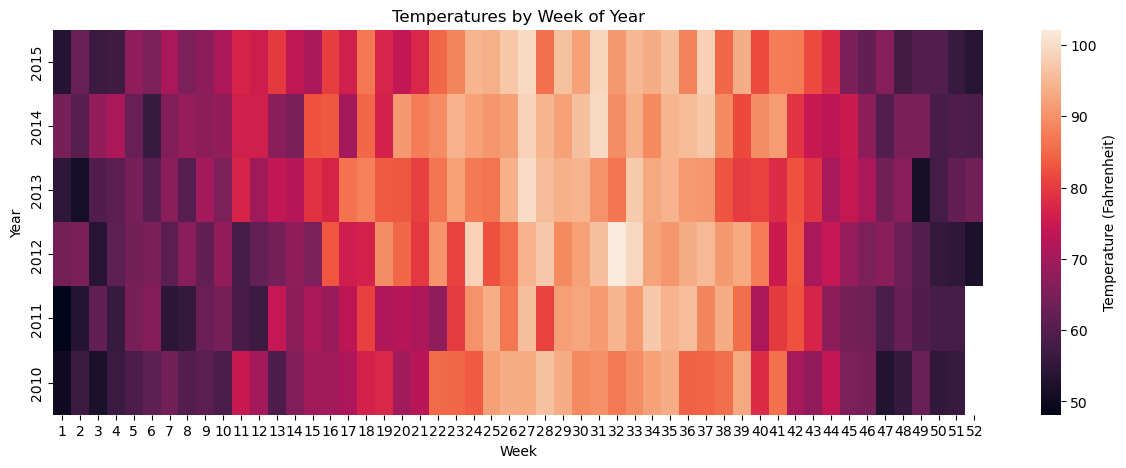

In [13]:
# heatmap shows hotter temperatures during summer months as expected
plt.figure(figsize=(15,5))
sns.heatmap(pivoted, cbar_kws={'label':'Temperature (Fahrenheit)'})
plt.title('Temperatures by Week of Year')

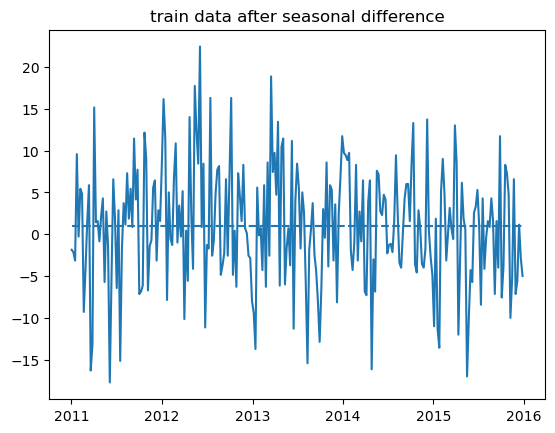

In [14]:
# definitely seasonal, weather seasons generally repeat every year
# remove seasonality with 52 week difference
weather_train['TMAXseasondiff'] = weather_train['TMAX'].diff(periods=52)

# drop nans from taking difference
seasonaldiff = weather_train['TMAXseasondiff'].dropna()

# plot to check that seasonality is removed
plt.title('train data after seasonal difference')
plt.plot(seasonaldiff)
plt.hlines(y=np.mean(seasonaldiff), xmin=np.min(seasonaldiff.index), xmax=np.max(seasonaldiff.index), linestyles='dashed')

In [15]:
# check for stationarity - augmented dickey-fuller test
# null hypothesis: series has unit root/is NOT stationary
ADF_pval = sm.tsa.stattools.adfuller(seasonaldiff)[1]
print(f'ADF p-value: {ADF_pval}')

ADF p-value: 2.0078840527945422e-26


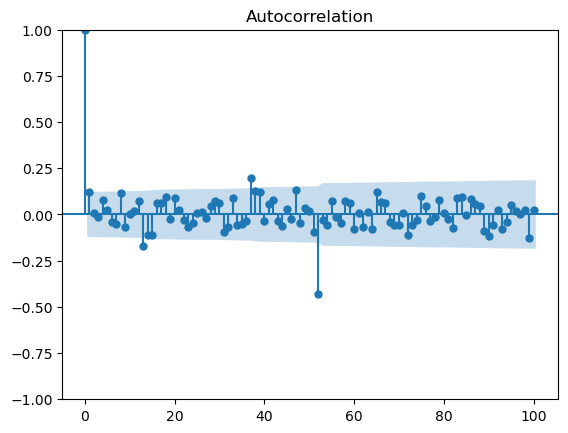

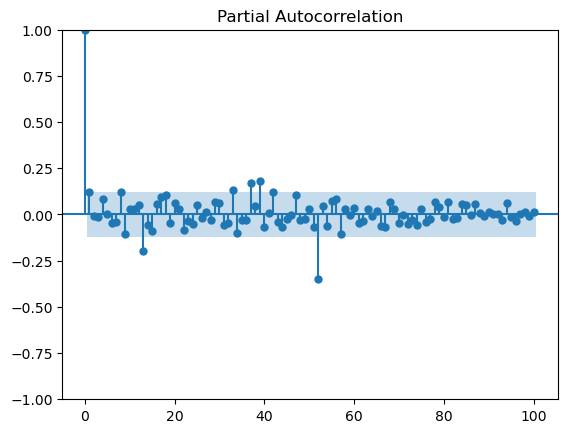

In [16]:
# plot ACF and PACF
acfplot = sm.graphics.tsa.plot_acf(seasonaldiff, lags=100)
pacfplot = sm.graphics.tsa.plot_pacf(seasonaldiff, lags=100)

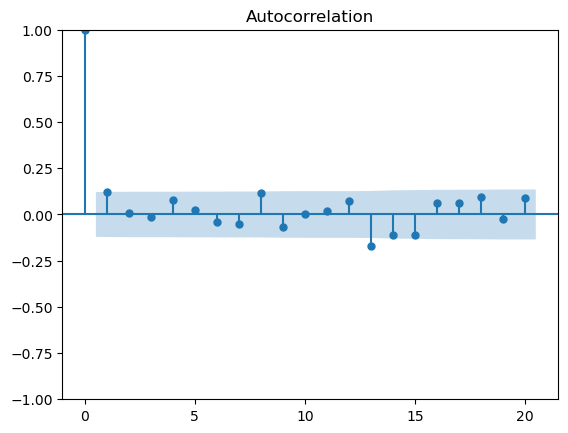

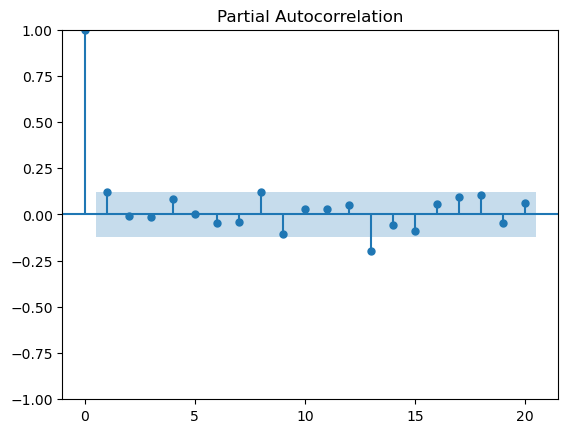

In [17]:
# plot ACF and PACF
acfplot = sm.graphics.tsa.plot_acf(seasonaldiff, lags=20)
pacfplot = sm.graphics.tsa.plot_pacf(seasonaldiff, lags=20)

initial model SARIMA (0,0,0) x (0,1,0,52)

In [18]:
# define seasonal ARIMA --> SARIMA
# try just a seasonal difference
model = sm.tsa.SARIMAX(weather_train['TMAX'], order=(0, 0, 0), seasonal_order=(0, 1, 0, 52))
# fit model
start = time()
model_fit = model.fit()
end = time()
print(f'time: {end - start}')

time: 0.1245737075805664


In [19]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                     TMAX   No. Observations:                  313
Model:             SARIMAX(0, 1, 0, 52)   Log Likelihood                -882.272
Date:                  Thu, 31 Oct 2024   AIC                           1766.545
Time:                          22:38:26   BIC                           1770.109
Sample:                      01-03-2010   HQIC                          1767.977
                           - 12-27-2015                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        50.5432      4.375     11.552      0.000      41.968      59.119
===================================================================================
Ljung-Box (L1) (Q):                   4.01   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.05   Prob(JB):                         0.96
Heteroskedasticity (H):               0.63   Skew:                            -0.03
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
def calc_error(residuals, test_data):
    # calculate RMSE
    rmse = np.sqrt(np.mean(residuals**2))
    print(f'RMSE: {rmse}')
    
    # calculate MAPE
    mape = np.mean(abs(residuals/test_data))
    print(f'MAPE: {mape}')

In [21]:
# make predictions with model 
pred = model_fit.get_forecast(steps=len(weather_test))
# pred.index = weather_test.index
residuals = weather_test['TMAX'] - pred.predicted_mean

# calculate RMSE and MAPE
calc_error(residuals, test_data=weather_test['TMAX'])

RMSE: 6.117632851940855
MAPE: 0.06411634448437341


In [22]:
def plot_resid(residuals):
    plt.figure(figsize=(6,4))
    plt.plot(residuals)
    plt.hlines(y=0, xmin=np.min(residuals.index), xmax=np.max(residuals.index), linestyles='dashed')
    plt.title('Residuals')

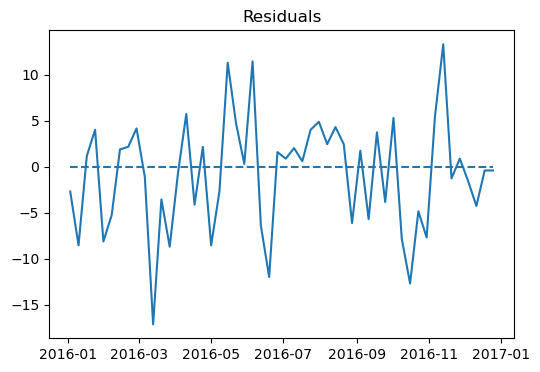

In [23]:
plot_resid(residuals)

In [24]:
def plot_forecast(train_data, test_data, predictions):
    # concatenate train and test data
    traintest = pd.concat([train_data, test_data])
    # get mean and confidence interval bounds from forecast object
    mu = predictions.predicted_mean
    ci_lower = predictions.conf_int().iloc[:,0]
    ci_upper = predictions.conf_int().iloc[:,1]

    # plot
    plt.figure(figsize=(15,5))
    plt.plot(traintest, label='actual data')
    plt.plot(mu, label='predictions')
    plt.fill_between(mu.index, ci_lower, ci_upper, alpha=0.1)
    plt.title('Actual Data with Temperature Forecast, 95% CI')
    plt.legend()

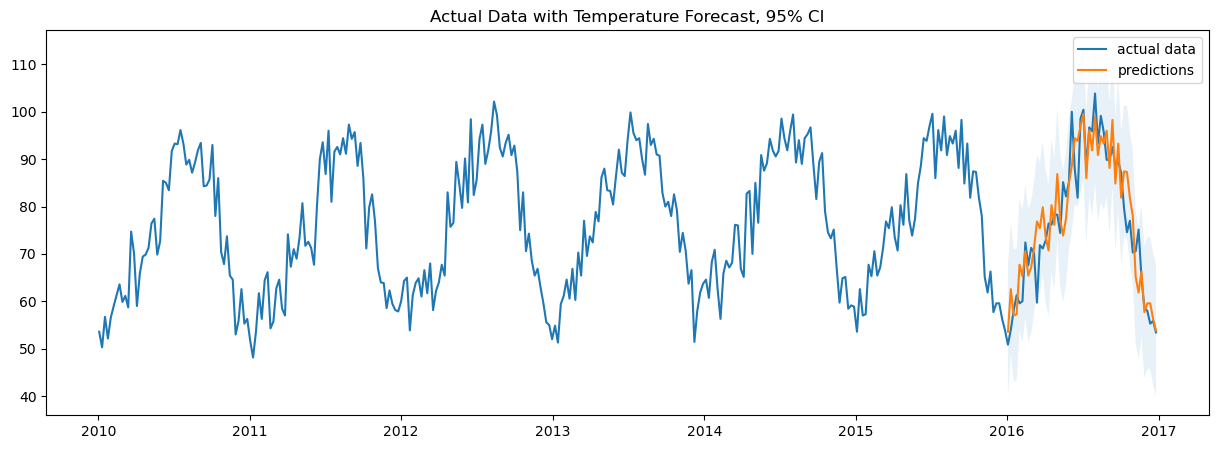

In [25]:
# plot actual data with predictions
plot_forecast(train_data=weather_train['TMAX'], test_data=weather_test['TMAX'], predictions=pred)

model SARIMA (0,0,0) x (0,1,1,52)

In [26]:
# define seasonal ARIMA --> SARIMA
# try a seasonal difference with seasonal moving average
model = sm.tsa.SARIMAX(weather_train['TMAX'], order=(0, 0, 0), seasonal_order=(0, 1, 1, 52))
# fit model
start = time()
model_fit = model.fit()
end = time()
print(f'time: {end - start}')

time: 1.8798189163208008


In [27]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                       TMAX   No. Observations:                  313
Model:             SARIMAX(0, 1, [1], 52)   Log Likelihood                -848.478
Date:                    Thu, 31 Oct 2024   AIC                           1700.956
Time:                            22:38:29   BIC                           1708.085
Sample:                        01-03-2010   HQIC                          1703.822
                             - 12-27-2015                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -0.6443      0.083     -7.809      0.000      -0.806      -0.483
sigma2        35.0918      3.768      9.312      0.000      27.706      42.478
===================================================================================
Ljung-Box (L1) (Q):                   4.33   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.04   Prob(JB):                         0.44
Heteroskedasticity (H):               0.60   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# make predictions with model 
pred = model_fit.get_forecast(steps=len(weather_test))
residuals = weather_test['TMAX'] - pred.predicted_mean

# calculate RMSE and MAPE
calc_error(residuals, test_data=weather_test['TMAX'])

RMSE: 4.7152068328874694
MAPE: 0.05128581576735728


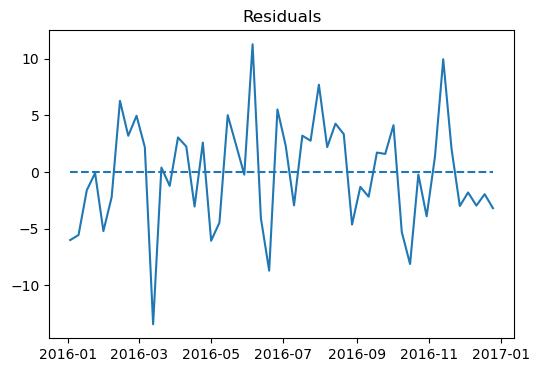

In [29]:
plot_resid(residuals)

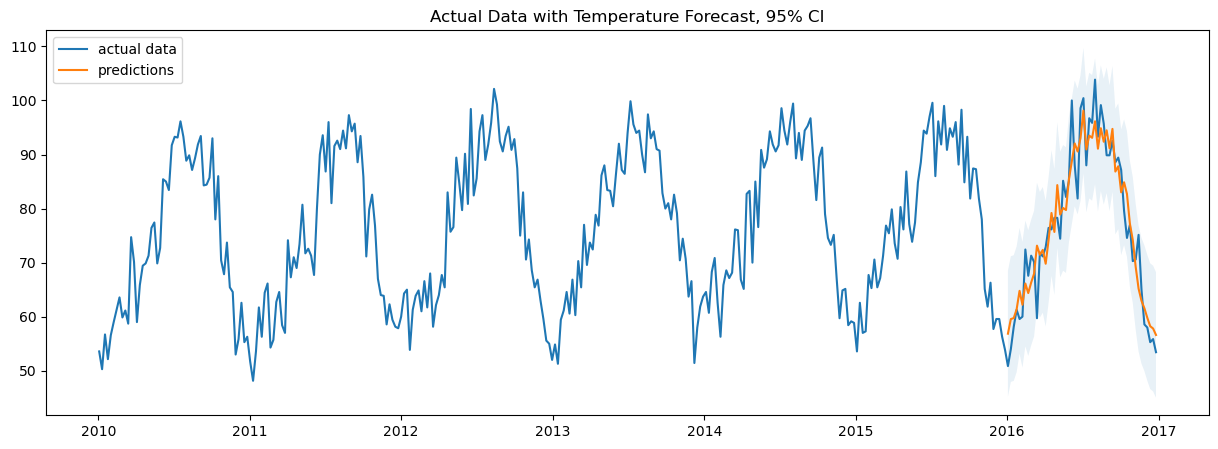

In [30]:
# plot actual data with predictions
plot_forecast(train_data=weather_train['TMAX'], test_data=weather_test['TMAX'], predictions=pred)

model SARIMA (0,0,1) x (0,1,1,52)

In [31]:
# define seasonal ARIMA --> SARIMA
# try a seasonal difference with seasonal moving average, and non-seasonal moving average
model = sm.tsa.SARIMAX(weather_train['TMAX'], order=(0, 0, 1), seasonal_order=(0, 1, 1, 52))
# fit model
start = time()
model_fit = model.fit()
end = time()
print(f'time: {end - start}')

time: 8.538698673248291


In [32]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               TMAX   No. Observations:                  313
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -842.272
Date:                            Thu, 31 Oct 2024   AIC                           1690.543
Time:                                    22:38:39   BIC                           1701.237
Sample:                                01-03-2010   HQIC                          1694.842
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2062      0.061      3.399      0.001       0.087       0.325
ma.S.L52      -0.7334      0.101     -7.228      0.000      -0.932      -0.535
sigma2        32.0450      3.725      8.603      0.000      24.744      39.346
===================================================================================
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                 1.96
Prob(Q):                              0.20   Prob(JB):                         0.38
Heteroskedasticity (H):               0.62   Skew:                            -0.21
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# make predictions with model 
pred = model_fit.get_forecast(steps=len(weather_test))
residuals = weather_test['TMAX'] - pred.predicted_mean

# calculate RMSE and MAPE
calc_error(residuals, test_data=weather_test['TMAX'])

RMSE: 4.6806677839963555
MAPE: 0.050888696968539225


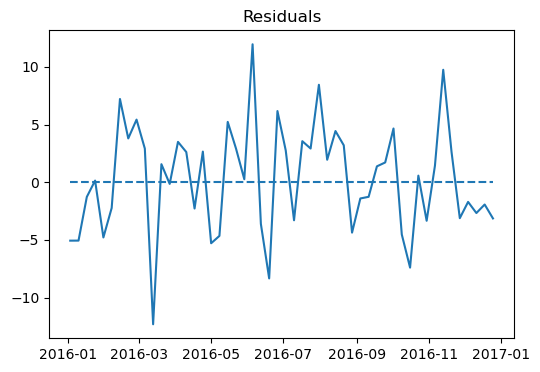

In [34]:
plot_resid(residuals)

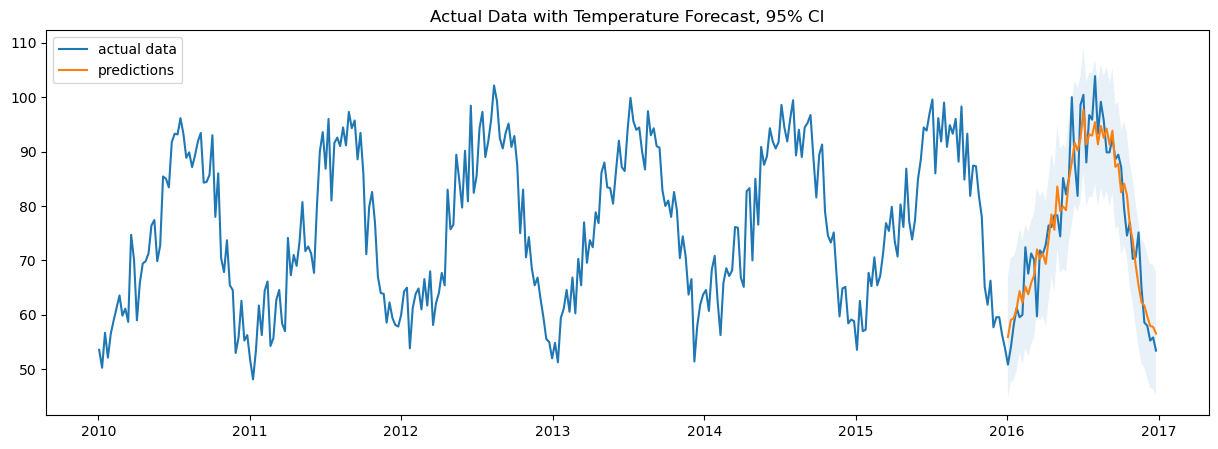

In [35]:
# plot actual data with predictions
plot_forecast(train_data=weather_train['TMAX'], test_data=weather_test['TMAX'], predictions=pred)

see if rolling prediction improves model prediction...

In [36]:
# rolling predictions, simulated
# fit model on train set, predict on next future time point
# add actual data point when obtained, refit model with new data point
# predict again on next future data point
traintest = pd.concat([weather_train['TMAX'], weather_test['TMAX']])
numtrain = len(weather_train['TMAX'])
cis = pd.DataFrame()
mus = pd.Series()
for i in range(len(weather_test) - 1):
    # add next data point to trainset
    train = traintest[:(numtrain + i)]
    # print(len(train), end=',')
    # define model and fit on train set
    model = sm.tsa.SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 1, 1, 52))
    model_fit = model.fit()
    #  predict one data point ahead
    nextpred = model_fit.get_prediction(traintest.index[numtrain + i + 1])
    # print(nextpred.summary_frame())
    # print(nextpred.conf_int())
    cis = pd.concat([cis, nextpred.conf_int()])
    mus = pd.concat([mus, nextpred.predicted_mean])

C:\Users\jench\AppData\Local\Temp\ipykernel_3616\1232090631.py:21: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  mus = pd.concat([mus, nextpred.predicted_mean])


In [37]:
# predictions
rollpred = cis
rollpred['mu'] = mus
residuals = weather_test['TMAX'] - rollpred['mu']

# calculate RMSE and MAPE
calc_error(residuals, test_data=weather_test['TMAX'])

RMSE: 4.702458820118446
MAPE: 0.050223747277374414


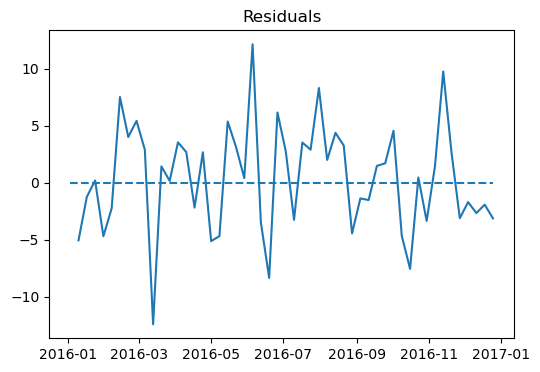

In [38]:
plot_resid(residuals)

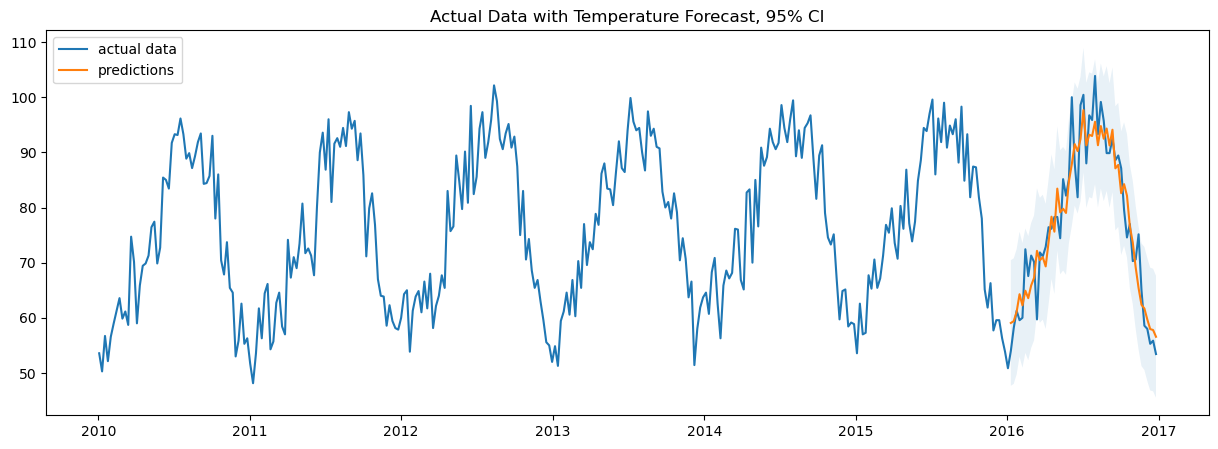

In [39]:
# plot actual data with rolling predictions
# get mean and confidence interval bounds
mu = rollpred['mu']
ci_lower = rollpred.iloc[:,0]
ci_upper = rollpred.iloc[:,1]

# plot
plt.figure(figsize=(15,5))
plt.plot(traintest, label='actual data')
plt.plot(mu, label='predictions')
plt.fill_between(mu.index, ci_lower, ci_upper, alpha=0.1)
plt.title('Actual Data with Temperature Forecast, 95% CI')
plt.legend()